In [70]:
# importing the libraries and files

import math
from collections import Counter
from functools import reduce
import ast

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
import seaborn as sns
from statsmodels.stats import diagnostic

from src.data.utils import get_franchise_movies, get_franchise_data

# setting the color theme for the plots
sns.set_theme(style='darkgrid', palette='colorblind', color_codes=True)

In [18]:
# loading the completed dataset
movies_df = pd.read_csv('data/movie_metadata_with_tmdb.csv')

# keeping only movies in franchises
franchise_df = get_franchise_movies(movies_df)

### Basic numerical analysis

In [19]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(franchise_counts.describe())
print(f"Number of movies in collections: {len(franchise_df['collection_id'])}")

count    1595.000000
mean        3.243260
std         3.751337
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        66.000000
Name: Wikipedia movie ID, dtype: float64
Number of movies in collections: 5173


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 

Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).

### Basic visualization

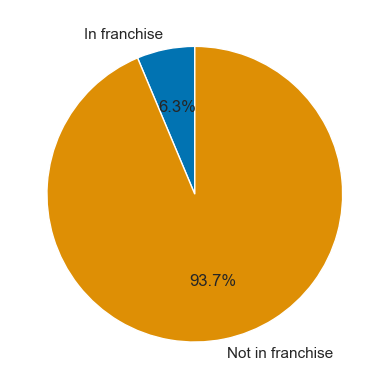

In [50]:
proportion = len(franchise_df) / len(movies_df)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In franchise', 'Not in franchise'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], labels=proportions.index, autopct='%1.1f%%', startangle=90)

plt.show()

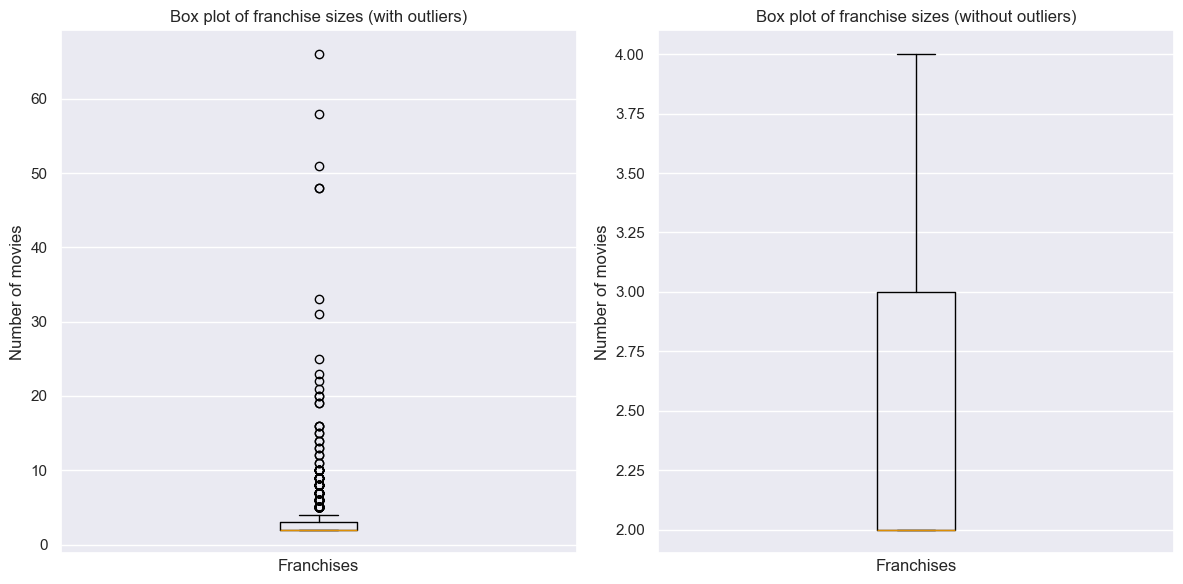

In [55]:
# Plot the box plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot with outliers
axes[0].boxplot(franchise_counts)
axes[0].set_title('Box plot of franchise sizes (with outliers)')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Franchises')
axes[0].set_xticks([])

# Boxplot without outliers
axes[1].boxplot(franchise_counts, showfliers=False)
axes[1].set_title('Box plot of franchise sizes (without outliers)')
axes[1].set_ylabel('Number of movies')
axes[1].set_xlabel('Franchises')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

### Focusing on genres

Now, we wanted to look more closely at the genre columns, as it is one of the parameters needed to answer our research questions. First, let's plot the genre proportions in the original dataset, with all the movies.

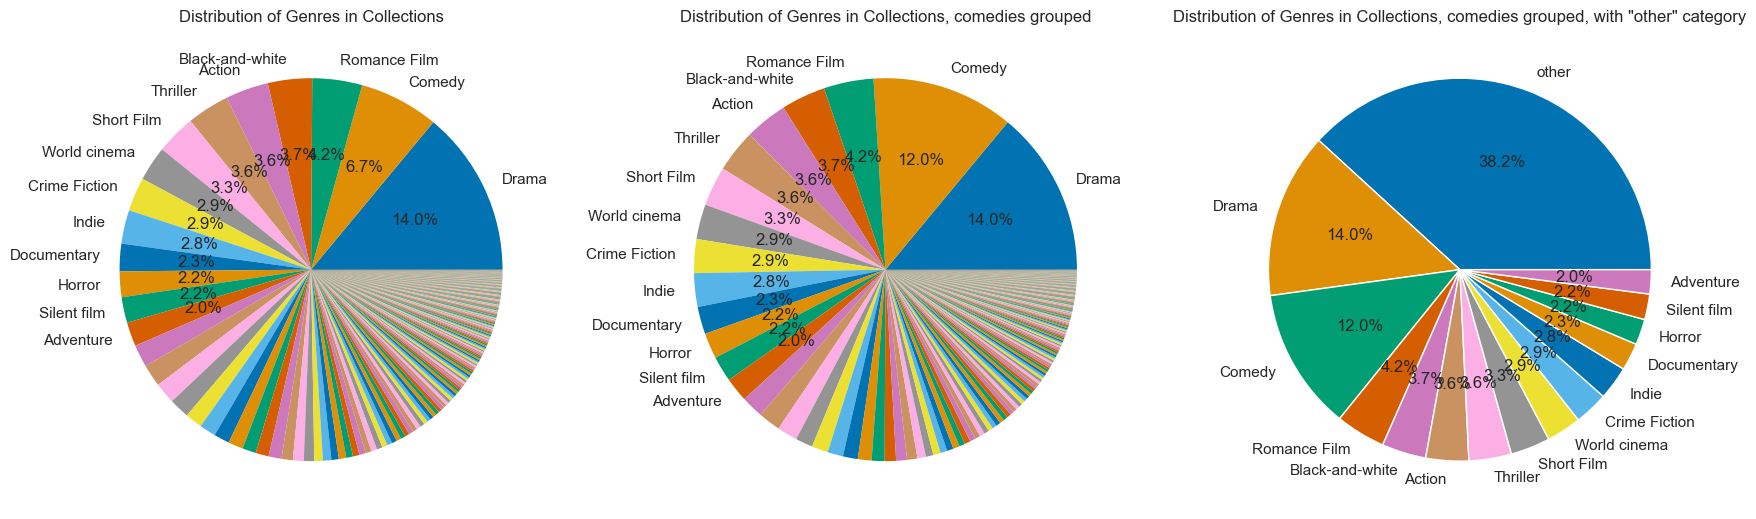

In [77]:
genre_counts = Counter()

for genres in movies_df['Movie genres (Freebase ID:name tuples)']:
    if pd.notnull(genres):
        # Split the genres by comma and strip any extra spaces
        genre_list = [genre.split(":")[1].strip().replace("}", "") for genre in genres.split(",") if ":" in genre]
        genre_counts.update(genre_list)

genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts']).reset_index()
genre_counts_df.columns = ['genre', 'counts']
genre_counts_df['genre']=genre_counts_df['genre'].str.replace('}','')
genre_counts_df = genre_counts_df.sort_values(by='counts', ascending=False)
# Clean up genre names by removing double quotes
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace('"', '')

# Calculate the total count of all genres
total_genres_count = genre_counts_df['counts'].sum()
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 10))

ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in Collections')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)

# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in Collections, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in Collections, comedies grouped, with "other" category')

plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

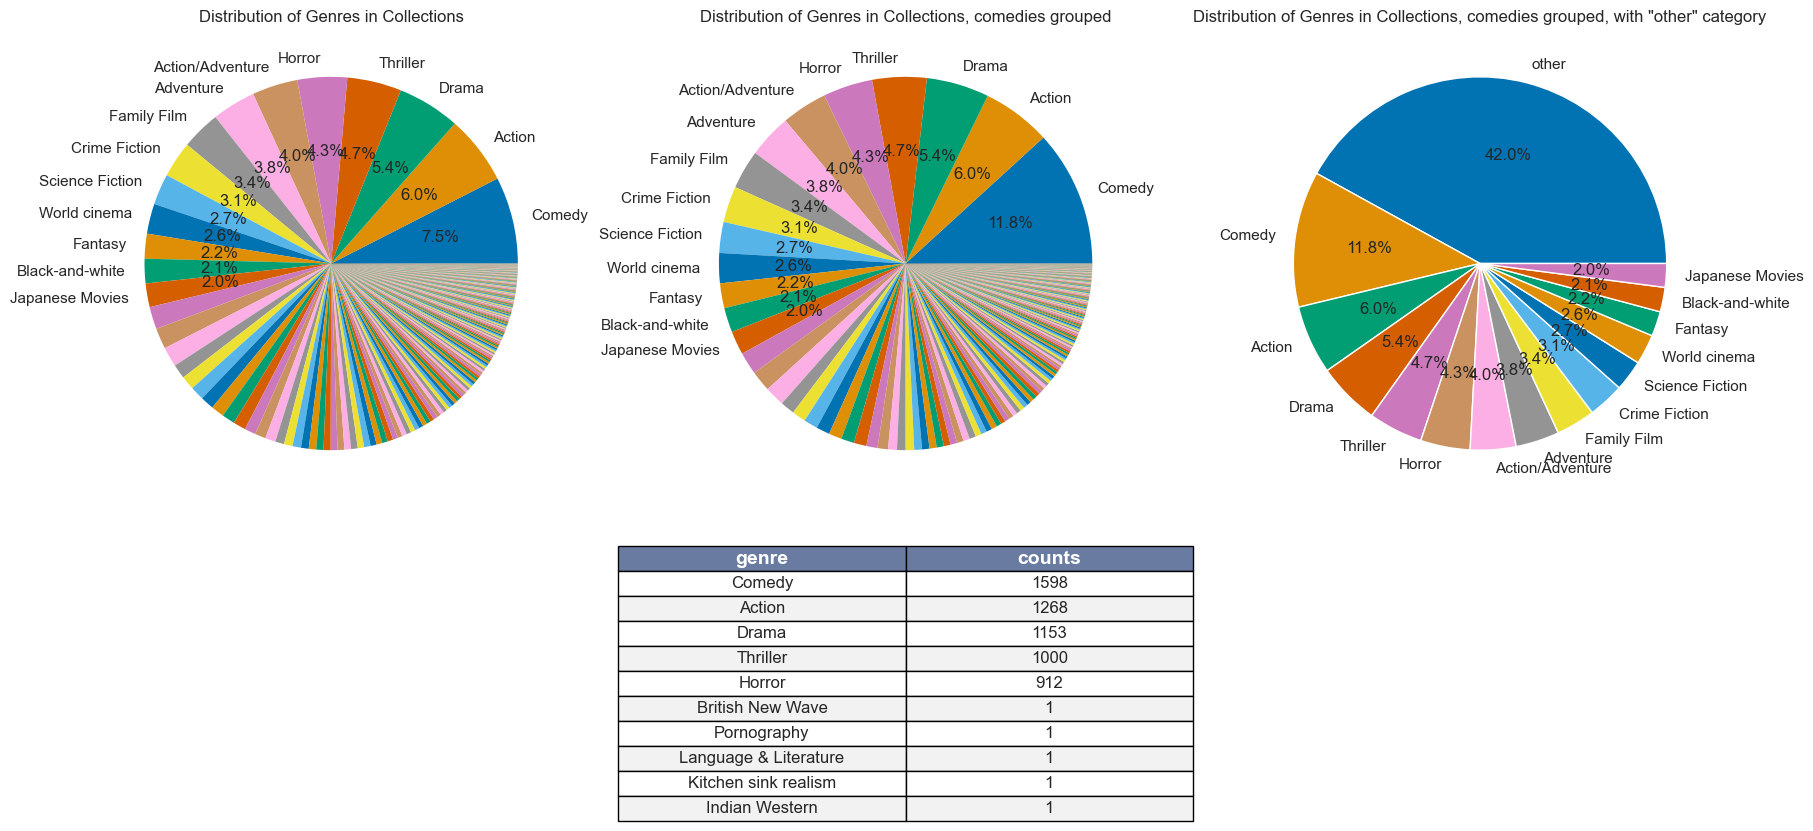

In [73]:
genre_counts = Counter()

for genres in franchise_df['Movie genres (Freebase ID:name tuples)']:
    if pd.notnull(genres):
        # Split the genres by comma and strip any extra spaces
        genre_list = [genre.split(":")[1].strip().replace("}", "") for genre in genres.split(",") if ":" in genre]
        genre_counts.update(genre_list)

genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts']).reset_index()
genre_counts_df.columns = ['genre', 'counts']
genre_counts_df['genre']=genre_counts_df['genre'].str.replace('}','')
genre_counts_df = genre_counts_df.sort_values(by='counts', ascending=False)
# Clean up genre names by removing double quotes
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace('"', '')

# Calculate the total count of all genres
total_genres_count = genre_counts_df['counts'].sum()
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig = plt.figure(figsize=(21, 10))
gs = GridSpec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in Collections')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)


# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in Collections, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3 = fig.add_subplot(gs[0, 2])
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in Collections, comedies grouped, with "other" category')

# Extract top 5 and bottom 5 genres
top_5_genres = genre_counts_df.head(5)
bottom_5_genres = genre_counts_df.tail(5)
# Combine top 5 and bottom 5 genres into a single DataFrame
top_bottom_genres = pd.concat([top_5_genres, bottom_5_genres])

# Plot the table with top 5 and bottom 5 genres
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Create the table
table = ax4.table(cellText=top_bottom_genres.values,
                 colLabels=top_bottom_genres.columns,
                 cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Display the table
plt.show()

Now, we know that there are a lot of unique, very specific and irrelevant genres in the original categories (such as "Kitchen sink realism"), that appear less than 2% and together represent 42% of the whole genres. We therefore chose to use the ones in the added TMDB dataset.

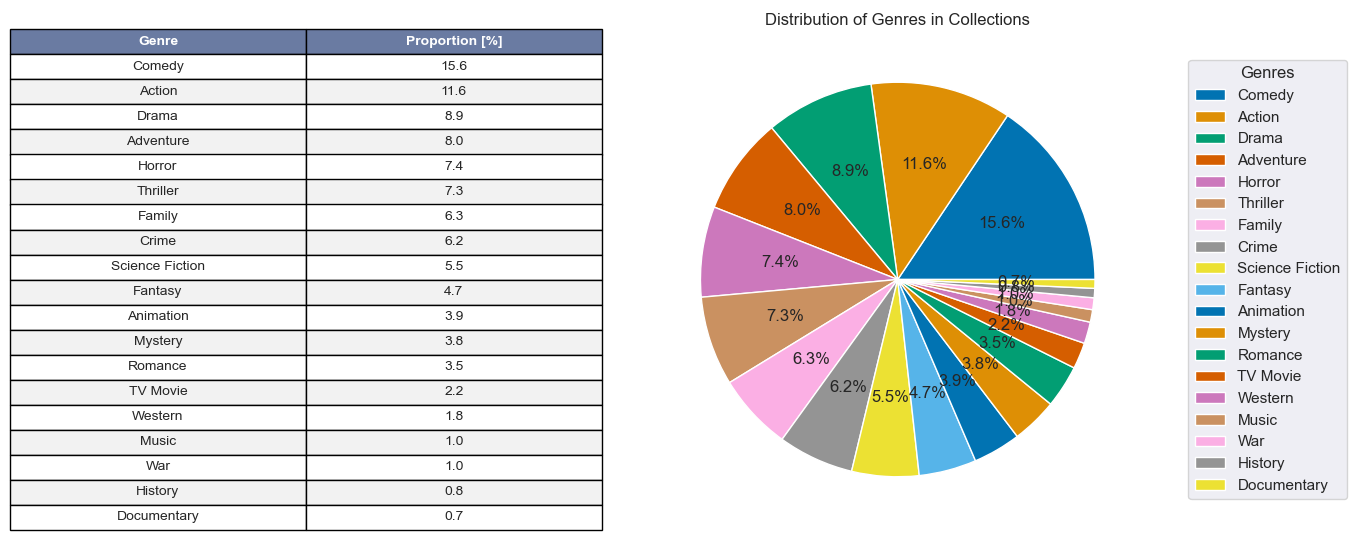

In [75]:
# Function to extract genre names from the string representation of the list of dictionaries
def extract_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres_list]
    except (ValueError, SyntaxError):
        return []

# Apply the function to the 'genres' column
franchise_df.loc[:, 'cleaned_genres'] = franchise_df['genres'].apply(extract_genres)

# Flatten the list of genres and count the occurrences
flattened_genres = [genre for sublist in franchise_df['cleaned_genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_counts_df.columns = ['genre', 'count']

# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Calculate the proportion of each genre
genre_counts_df['proportion [%]'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 100
genre_counts_df = genre_counts_df.sort_values(by='proportion [%]', ascending=False)

# Plot the table with genre proportions
genre_counts_df['proportion [%]'] = genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))
ax1.axis('off')
table = ax1.table(cellText=genre_counts_df[['genre', 'proportion [%]']].values,
                  colLabels=['Genre', 'Proportion [%]'],
                  cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Plot the pie chart with labels only on the side
wedges, texts, autotexts = ax2.pie(genre_counts_df['count'], labels=['']*len(genre_counts_df), autopct='%1.1f%%')
ax2.legend(wedges, genre_counts_df['genre'], title="Genres", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title('Distribution of Genres in Collections')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1., 1.)

plt.show()

This looks better ! And we still have the same top 3 genre ! But this is still for all the genres mentionned in the dataset. What if we look only at the ones present in all movies in a collection ? 

for all common genres

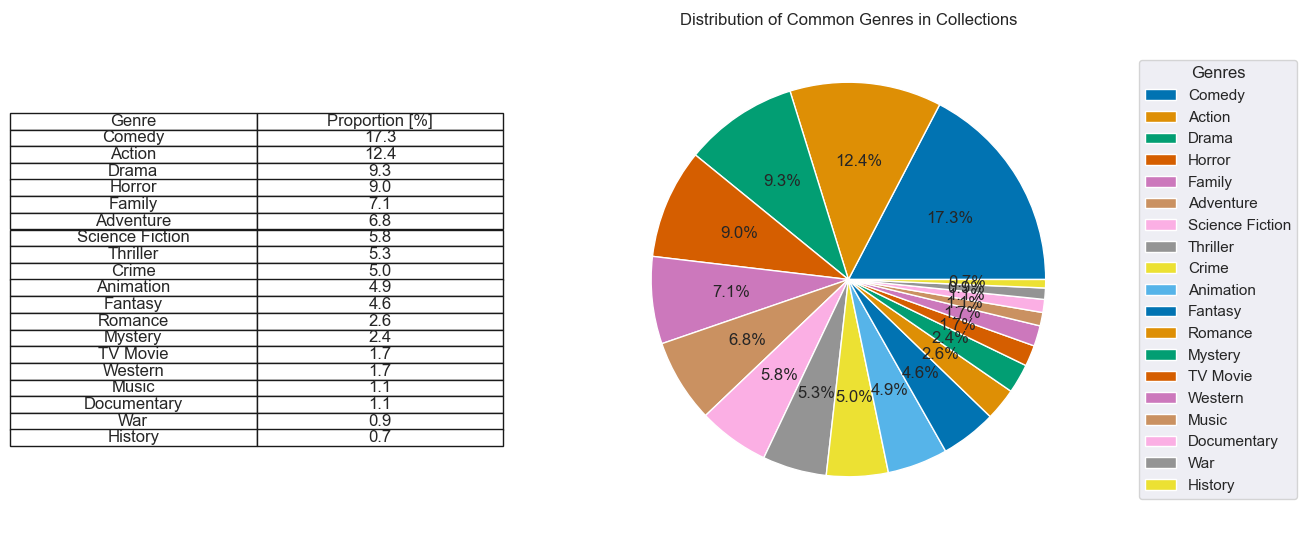

              genre  counts  proportion [%]
6            Comedy     505            17.3
2            Action     362            12.4
4             Drama     272             9.3
12           Horror     262             9.0
8            Family     208             7.1
0         Adventure     199             6.8
1   Science Fiction     170             5.8
7          Thriller     153             5.3
5             Crime     147             5.0
11        Animation     144             4.9
3           Fantasy     133             4.6
10          Romance      77             2.6
9           Mystery      70             2.4
16         TV Movie      50             1.7
15          Western      49             1.7
14            Music      32             1.1
17      Documentary      31             1.1
13              War      27             0.9
18          History      20             0.7


In [78]:
###################################################  TESTING  ########################################################

# Group by 'collection_id' and find common genres in each collection
common_genres_list = []
common_genre_counts = Counter()

for collection_id, group in franchise_df.groupby('collection_id'):
    # Filter out null values and split the genres by comma
    genre_sets = group['cleaned_genres'].apply(set)
    
    if len(genre_sets) > 0:
        # Find the intersection of all genre sets in the collection
        common_genres = reduce(set.intersection, genre_sets)
        common_genres_list.append((collection_id, common_genres))
        common_genre_counts.update(common_genres)

# Convert the list of tuples to a DataFrame
common_genres_df = pd.DataFrame.from_dict(common_genre_counts, orient='index', columns=['counts']).reset_index()
common_genres_df.columns = ['genre', 'counts']

# Plotting the pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Calculate the proportion of each genre
common_genres_df['proportion [%]'] = common_genres_df['counts'] / common_genres_df['counts'].sum() * 100
common_genres_df = common_genres_df.sort_values(by='proportion [%]', ascending=False)

# Plot the table with genre proportions
common_genres_df['proportion [%]'] = common_genres_df['proportion [%]'].apply(lambda x: round(x, 1))
ax1.axis('off')
table = ax1.table(cellText=common_genres_df[['genre', 'proportion [%]']].values,
                  colLabels=['Genre', 'Proportion [%]'],
                  cellLoc='center', loc='center')

# Plot the pie chart with labels only on the side
wedges, texts, autotexts = ax2.pie(common_genres_df['counts'], labels=['']*len(common_genres_df), autopct='%1.1f%%')
ax2.legend(wedges, common_genres_df['genre'], title="Genres", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title('Distribution of Common Genres in Collections')

plt.show()
print(common_genres_df)

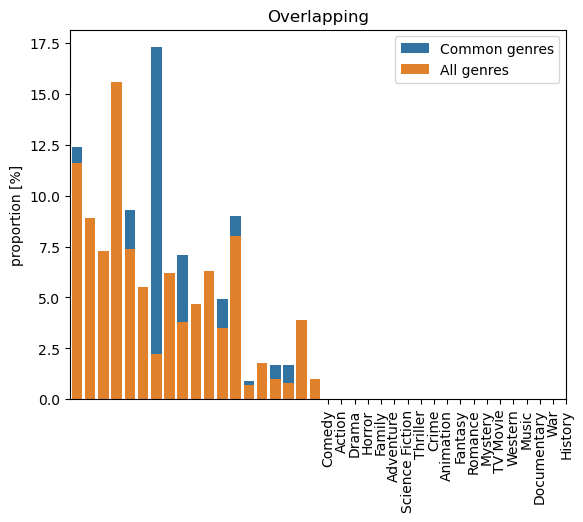

In [ ]:
### OR

sns.barplot(common_genres_df['proportion [%]'], label='Common genres')
  
sns.barplot(genre_counts_df['proportion [%]'],  label='All genres') 
plt.xticks(ticks = common_genres_df['genre'], rotation=90)
plt.legend(loc='upper right') 
plt.title('Overlapping of genre proportions, common genres vs all genres') 
plt.show()

Empty DataFrame
Columns: [genre, counts]
Index: []


Text(0.5, 1.0, 'Distribution of Common Genres in Collections')

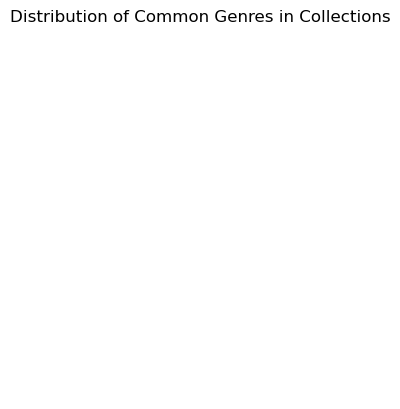

In [ ]:
common_genres_list = []
common_genre_counts = Counter()

for collection_id, group in genre_counts_df['genre']:
    if pd.notnull(genres):
        genre_sets = [genres in group['genre'] if pd.notnull(genres)]
        # Find the intersection of all genre sets in the collection
        common_genres = reduce(set.intersection, genre_sets)
        common_genres_list.append((collection_id, common_genres))
        common_genre_counts.update(common_genres)

genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts']).reset_index()
genre_counts_df.columns = ['genre', 'counts']
print(genre_counts_df.sort_values(by='counts', ascending=False))


# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(genre_counts_df['counts'], labels=genre_counts_df['genre'], autopct='%1.1f%%')
plt.title('Distribution of Common Genres in Collections')

                                            counts
"Thriller"                                     176
"Comedy"                                       166
"Drama"                                        165
"Action/Adventure"                             152
"Horror"                                       134
...                                            ...
"Archaeology"                                    1
"Apocalyptic and post-apocalyptic fiction"       1
"Costume Horror"}                                1
"Dystopia"}                                      1
"Silent film"}                                   1

[217 rows x 1 columns]


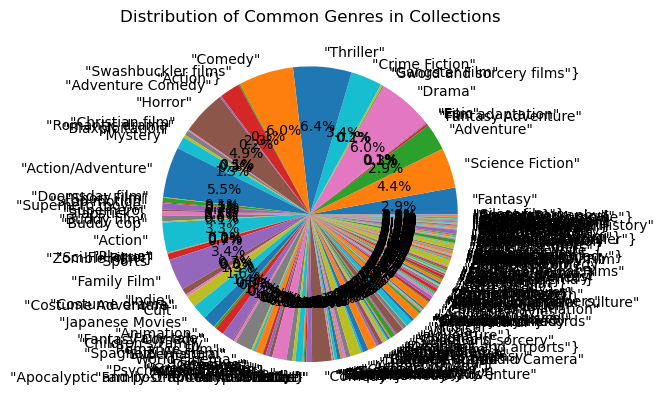

In [ ]:
# Group by 'collection_id' and find common genres in each collection
common_genres_list = []

for collection_id, group in collections.groupby('collection_id'):
    # Filter out null values and split the genres by comma
    genre_sets = [set(genre.split(":")[1].strip() for genre in genres.split(",") if ":" in genre) 
                  for genres in group['Movie genres (Freebase ID:name tuples)'] if pd.notnull(genres)]
    
    if genre_sets:
        # Find the intersection of all genre sets in the collection
        common_genres = reduce(set.intersection, genre_sets)
        common_genres_list.append((collection_id, common_genres))

# Convert the list of tuples to a DataFrame
common_genres_df = pd.DataFrame(common_genres_list, columns=['collection_id', 'common_genres'])

# Flatten the list of common genres
flattened_genres = [genre for genres in common_genres_df['common_genres'] for genre in genres]

# Count the occurrences of each genre
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['counts'])
print(genre_counts_df.sort_values(by='counts', ascending=False))


# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(genre_counts_df['counts'], labels=genre_counts_df.index, autopct='%1.1f%%')
plt.title('Distribution of Common Genres in Collections')
plt.show()

keep only 1 genre in common genres ? the ones that appear most likely \
here I put "other" category for genres appearing less than 1%

In [ ]:
# Calculate the total count of all genres
total_common_genres_count = common_genres_df['counts'].sum()

# Determine the threshold count for 1%
threshold_count = total_common_genres_count * 0.01

# Replace genres with counts below the threshold with "other"
common_genres_df['genre'] = common_genres_df.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)

# Group by the new category and sum the counts
common_genres_df = common_genres_df.groupby('genre')['counts'].sum().reset_index()

print(common_genres_df.sort_values(by='counts', ascending=False))

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(common_genres_df['counts'], labels=common_genres_df['genre'], autopct='%1.1f%%')
plt.title('Distribution of Genres in Collections (with "other" category)')
plt.show()

KeyError: 'counts'

have to look more closely at genres name and agree